In [ ]:
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

from tensorflow import keras

# 1. Read the Dataset

In [ ]:
# Read the labels
labels = pd.read_csv("../data/data.info.labelled", sep=',')
labels.head()

,gene_id,transcript_id,transcript_position,label
0,ENSG00000004059,ENST00000000233,244,0
1,ENSG00000004059,ENST00000000233,261,0
2,ENSG00000004059,ENST00000000233,316,0
3,ENSG00000004059,ENST00000000233,332,0
4,ENSG00000004059,ENST00000000233,368,0


In [ ]:
# Read the data (as df)
file_path = "../data/dataset0.json.gz"
rows = []

with gzip.open(file_path, 'rt', encoding='utf-8') as f:
    for line in f:
        data = json.loads(line)
        for transcript_id, positions in data.items():
            for transcript_position, sequences in positions.items():
                for sequence, feature_list in sequences.items():
                    for features in feature_list:
                        row = {
                            'transcript_id': transcript_id,
                            'transcript_position': int(transcript_position),
                            'sequence': sequence,
                            'dwell_-1': features[0],
                            'std_-1': features[1],
                            'mean_-1': features[2],
                            'dwell_0': features[3],
                            'std_0': features[4],
                            'mean_0': features[5],
                            'dwell_+1': features[6],
                            'std_+1': features[7],
                            'mean_+1': features[8],
                        }
                        rows.append(row)

df = pd.DataFrame(rows)

# Add gene_id from labels to df
df = pd.merge(df, labels, on=['transcript_id', 'transcript_position'], how='left')
df = df.drop(columns=['label'])
df = df.iloc[:, [12, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
df.head()

,gene_id,transcript_id,transcript_position,sequence,dwell_-1,std_-1,mean_-1,dwell_0,std_0,mean_0,dwell_+1,std_+1,mean_+1
0,ENSG00000004059,ENST00000000233,244,AAGACCA,0.00299,2.06,125.0,0.01770,10.40,122.0,0.00930,10.90,84.1
1,ENSG00000004059,ENST00000000233,244,AAGACCA,0.00631,2.53,125.0,0.00844,4.67,126.0,0.01030,6.30,80.9
2,ENSG00000004059,ENST00000000233,244,AAGACCA,0.00465,3.92,109.0,0.01360,12.00,124.0,0.00498,2.13,79.6
3,ENSG00000004059,ENST00000000233,244,AAGACCA,0.00398,2.06,125.0,0.00830,5.01,130.0,0.00498,3.78,80.4
4,ENSG00000004059,ENST00000000233,244,AAGACCA,0.00664,2.92,120.0,0.00266,3.94,129.0,0.01300,7.15,82.2


In [32]:
# Analyse the structure of reads
print("Total number of rows in dataset:", len(df))
print("\nUnique (transcript_id, transcript_position) combinations:", 
      df.groupby(['transcript_id', 'transcript_position']).size().nunique())

# Check how many reads per position
reads_per_position = df.groupby(['transcript_id', 'transcript_position']).size()
print(f"\nReads per position statistics:")
print(f"Mean: {reads_per_position.mean():.2f}")
print(f"Median: {reads_per_position.median():.2f}")
print(f"Min: {reads_per_position.min()}")
print(f"Max: {reads_per_position.max()}")
print(f"Std: {reads_per_position.std():.2f}")

# Show examples of multiple reads for same position
print(f"\nExample of multiple reads for same position:")
example_group = df.groupby(['transcript_id', 'transcript_position']).get_group(
    df.groupby(['transcript_id', 'transcript_position']).size().idxmax()
)
print(example_group[['transcript_id', 'transcript_position', 'sequence', 'dwell_0', 'std_0', 'mean_0']].head(10))

Total number of rows in dataset: 11027106

Unique (transcript_id, transcript_position) combinations: 967

Unique (transcript_id, transcript_position) combinations: 967

Reads per position statistics:
Mean: 90.51
Median: 47.00
Min: 20
Max: 991
Std: 137.33

Example of multiple reads for same position:

Reads per position statistics:
Mean: 90.51
Median: 47.00
Min: 20
Max: 991
Std: 137.33

Example of multiple reads for same position:
           transcript_id  transcript_position sequence  dwell_0  std_0  mean_0
2376782  ENST00000278572                  559  TTAACTA  0.00266   0.95    93.7
2376783  ENST00000278572                  559  TTAACTA  0.00512   2.42    98.2
2376784  ENST00000278572                  559  TTAACTA  0.01100   3.00    97.1
2376785  ENST00000278572                  559  TTAACTA  0.00796   2.56    97.3
2376786  ENST00000278572                  559  TTAACTA  0.00398   3.29   102.0
2376787  ENST00000278572                  559  TTAACTA  0.01130   3.38    98.0
2376788  ENST

# 2. Feature Extraction

In [33]:
# Create aggregated features dataset for CNN
def create_cnn_features(group):
    """Create aggregated features for each (transcript_id, transcript_position)"""
    features = {}
    feature_cols = ['dwell_-1', 'std_-1', 'mean_-1', 'dwell_0', 'std_0', 'mean_0', 'dwell_+1', 'std_+1', 'mean_+1']
    
    for col in feature_cols:
        # Central tendency
        features[f'{col}_mean'] = group[col].mean()
        features[f'{col}_median'] = group[col].median()
        
        # Variability
        features[f'{col}_std'] = group[col].std()
        features[f'{col}_iqr'] = group[col].quantile(0.75) - group[col].quantile(0.25)
        
        # Distribution shape
        features[f'{col}_skew'] = group[col].skew()
        features[f'{col}_min'] = group[col].min()
        features[f'{col}_max'] = group[col].max()
        
        # Robust statistics
        features[f'{col}_q25'] = group[col].quantile(0.25)
        features[f'{col}_q75'] = group[col].quantile(0.75)
    
    # Add read count as a feature (coverage information)
    features['read_count'] = len(group)
    
    return pd.Series(features)

print("Creating aggregated features for CNN...")
cnn_features = df.groupby(['transcript_id', 'transcript_position']).apply(create_cnn_features, include_groups=False)
print(f"CNN feature matrix shape: {cnn_features.shape}")
print(f"Features per position: {cnn_features.shape[1]}")

# Show feature names
print(f"\nFeature categories created:")
print(f"- 9 original features x 9 statistics = {9*9} aggregated features")
print(f"- Plus read_count = {9*9 + 1} total features")
print(f"\nFirst few feature names:")
print(list(cnn_features.columns[:15]))

Creating aggregated features for CNN...
CNN feature matrix shape: (121838, 82)
Features per position: 82

Feature categories created:
- 9 original features x 9 statistics = 81 aggregated features
- Plus read_count = 82 total features

First few feature names:
['dwell_-1_mean', 'dwell_-1_median', 'dwell_-1_std', 'dwell_-1_iqr', 'dwell_-1_skew', 'dwell_-1_min', 'dwell_-1_max', 'dwell_-1_q25', 'dwell_-1_q75', 'std_-1_mean', 'std_-1_median', 'std_-1_std', 'std_-1_iqr', 'std_-1_skew', 'std_-1_min']
CNN feature matrix shape: (121838, 82)
Features per position: 82

Feature categories created:
- 9 original features x 9 statistics = 81 aggregated features
- Plus read_count = 82 total features

First few feature names:
['dwell_-1_mean', 'dwell_-1_median', 'dwell_-1_std', 'dwell_-1_iqr', 'dwell_-1_skew', 'dwell_-1_min', 'dwell_-1_max', 'dwell_-1_q25', 'dwell_-1_q75', 'std_-1_mean', 'std_-1_median', 'std_-1_std', 'std_-1_iqr', 'std_-1_skew', 'std_-1_min']


# 3. Implement CNN

In [34]:
# Reshape and rescale features and create train/test split
def prepare_cnn_data(features_df, labels_df, gene_train_ids):
    """Streamlined data preparation without redundant steps"""
    
    # Reshape features to (N, 3, 27) - exclude read_count
    feature_matrix = features_df.iloc[:, :-1].values.reshape(-1, 3, 27)
    
    # Get labels aligned with features
    y = labels_df.set_index(['transcript_id', 'transcript_position']).loc[features_df.index]['label'].values
    gene_mapping = labels_df.set_index(['transcript_id', 'transcript_position']).loc[features_df.index]['gene_id'].values
    
    # Single train/test split
    train_mask = np.isin(gene_mapping, gene_train_ids)
    
    X_train, X_test = feature_matrix[train_mask], feature_matrix[~train_mask]
    y_train, y_test = y[train_mask], y[~train_mask]
    
    # Scale features
    scaler = StandardScaler()
    
    # Fit on training data: reshape, scale, reshape back
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 27)).reshape(X_train.shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, 27)).reshape(X_test.shape)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, train_mask

# Split into 80-20 train-test based on gene_id
gene_ids = labels['gene_id'].unique()
training_n = int(0.8 * len(gene_ids))
gene_train = np.random.choice(gene_ids, size=training_n, replace=False)
X_train, X_test, y_train, y_test, train_mask = prepare_cnn_data(
    cnn_features, labels, gene_train
)
test_mask = ~train_mask

print(f"Streamlined data shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

Streamlined data shapes:
X_train: (98270, 3, 27), y_train: (98270,)
X_test: (23568, 3, 27), y_test: (23568,)
Training class distribution: [93803  4467]
Test class distribution: [22560  1008]


In [35]:
# Calculate class weights for imbalanced dataset
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

Class weights: {0: np.float64(0.5238105391085573), 1: np.float64(10.99955227221849)}


In [36]:
# Build CNN architecture
def create_cnn(input_shape=(3, 27), num_classes=1):
    """
    Create CNN
    Input: (3, 27) - 3 positions × 27 feature statistics
    """
    model = keras.Sequential([
        # Input layer
        keras.layers.Input(shape=input_shape),
        
        # First 1D Conv layer - scan across features within each position
        keras.layers.Conv1D(
            filters=64, 
            kernel_size=3, 
            activation='relu', 
            padding='same',
            name='conv1d_features'
        ),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        
        # Second 1D Conv layer - capture more complex feature patterns
        keras.layers.Conv1D(
            filters=32, 
            kernel_size=3, 
            activation='relu', 
            padding='same',
            name='conv1d_patterns'
        ),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        
        # Global features across positions
        keras.layers.GlobalMaxPooling1D(),
        
        # Dense layers for final classification
        keras.layers.Dense(64, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.2),
        
        # Output layer
        keras.layers.Dense(num_classes, activation='sigmoid', name='output')
    ])
    
    return model

# Create the model
model = create_cnn()
model.summary()

# Compile with appropriate metrics for imbalanced classification
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='pr_auc', curve='PR')
    ]
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_features (Conv1D)        │ (None, 3, 64)          │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_patterns (Conv1D)        │ (None, 3, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,289 (63.63 KB)

 Trainable params: 15,969 (62.38 KB)

 Non-trainable params: 320 (1.25 KB)

In [37]:
# Create validation split from training data (gene-level)
cnn_gene_mapping = labels.set_index(['transcript_id', 'transcript_position']).loc[cnn_features.index]['gene_id'].values
train_genes = np.unique(cnn_gene_mapping[train_mask])
val_size = int(0.2 * len(train_genes))
val_genes = np.random.choice(train_genes, size=val_size, replace=False)

val_mask = np.isin(cnn_gene_mapping[train_mask], val_genes)
train_final_mask = ~val_mask

X_train_final = X_train[train_final_mask]
X_val = X_train[val_mask]
y_train_final = y_train[train_final_mask]
y_val = y_train[val_mask]

print(f"Final training set: {X_train_final.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Training callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_pr_auc', 
        patience=10, 
        restore_best_weights=True,
        mode='max'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_pr_auc',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='max'
    ),
    keras.callbacks.ModelCheckpoint(
        'best_cnn_model.h5',
        monitor='val_pr_auc',
        save_best_only=True,
        mode='max'
    )
]

Final training set: 77356 samples
Validation set: 20914 samples
Test set: 23568 samples


In [38]:
# Train the CNN model
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=256,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
300/303 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6544 - auc: 0.7086 - loss: 0.6371 - pr_auc: 0.1215 - precision: 0.0798 - recall: 0.6416

303/303 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6803 - auc: 0.7773 - loss: 0.5753 - pr_auc: 0.1737 - precision: 0.0970 - recall: 0.7295 - val_accuracy: 0.8273 - val_auc: 0.8673 - val_loss: 0.4113 - val_pr_auc: 0.3412 - val_precision: 0.1775 - val_recall: 0.7536 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
299/303 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7518 - auc: 0.8506 - loss: 0.4953 - pr_auc: 0.2676 - precision: 0.1356 - recall: 0.7951

303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7615 - auc: 0.8537 - loss: 0.4813 - pr_auc: 0.2607 - precision: 0.1361 - recall: 0.7989 - val_accuracy: 0.8095 - val_auc: 0.8764 - val_loss: 0.4271 - val_pr_auc: 0.3618 - val_precision: 0.1680 - val_recall: 0.7909 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
298/303 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7901 - auc: 0.8661 - loss: 0.4641 - pr_auc: 0.2844 - precision: 0.1535 - recall: 0.7972

303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7943 - auc: 0.8688 - loss: 0.4575 - pr_auc: 0.2917 - precision: 0.1555 - recall: 0.7998 - val_accuracy: 0.8256 - val_auc: 0.8852 - val_loss: 0.4287 - val_pr_auc: 0.3759 - val_precision: 0.1813 - val_recall: 0.7899 - learning_rate: 0.0010
Epoch 4/50
Epoch 4/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8162 - auc: 0.8810 - loss: 0.4355 - pr_auc: 0.3257 - precision: 0.1712 - recall: 0.7969 - val_accuracy: 0.8001 - val_auc: 0.8890 - val_loss: 0.4764 - val_pr_auc: 0.3728 - val_precision: 0.1661 - val_recall: 0.8282 - learning_rate: 0.0010
Epoch 5/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8162 - auc: 0.8810 - loss: 0.4355 - pr_auc: 0.3257 - precision: 0.1712 - recall: 0.7969 - val_accuracy: 0.8001 - val_auc: 0.8890 - val_loss: 0.4764 - val_pr_auc: 0.3728 - val_precision: 0.1661 - val_recall: 0.8282 - learning_rate: 0.0010
Epoch 5/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8114 - auc: 0.8877 - 

303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8141 - auc: 0.8879 - loss: 0.4236 - pr_auc: 0.3313 - precision: 0.1723 - recall: 0.8163 - val_accuracy: 0.8197 - val_auc: 0.8920 - val_loss: 0.4348 - val_pr_auc: 0.3908 - val_precision: 0.1813 - val_recall: 0.8261 - learning_rate: 0.0010
Epoch 6/50
Epoch 6/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8240 - auc: 0.8910 - loss: 0.4175 - pr_auc: 0.3448 - precision: 0.1808 - recall: 0.8183 - val_accuracy: 0.8310 - val_auc: 0.8914 - val_loss: 0.4370 - val_pr_auc: 0.3842 - val_precision: 0.1888 - val_recall: 0.8064 - learning_rate: 0.0010
Epoch 7/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8240 - auc: 0.8910 - loss: 0.4175 - pr_auc: 0.3448 - precision: 0.1808 - recall: 0.8183 - val_accuracy: 0.8310 - val_auc: 0.8914 - val_loss: 0.4370 - val_pr_auc: 0.3842 - val_precision: 0.1888 - val_recall: 0.8064 - learning_rate: 0.0010
Epoch 7/50
301/303 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8254 - auc: 0.8986 - l

303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8280 - auc: 0.8930 - loss: 0.4133 - pr_auc: 0.3484 - precision: 0.1846 - recall: 0.8195 - val_accuracy: 0.8224 - val_auc: 0.8951 - val_loss: 0.4452 - val_pr_auc: 0.4006 - val_precision: 0.1835 - val_recall: 0.8251 - learning_rate: 0.0010
Epoch 8/50
Epoch 8/50
296/303 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8262 - auc: 0.8989 - loss: 0.4004 - pr_auc: 0.3403 - precision: 0.1812 - recall: 0.8234

303/303 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8288 - auc: 0.8978 - loss: 0.4046 - pr_auc: 0.3558 - precision: 0.1860 - recall: 0.8238 - val_accuracy: 0.8426 - val_auc: 0.8969 - val_loss: 0.4018 - val_pr_auc: 0.4058 - val_precision: 0.2004 - val_recall: 0.8054 - learning_rate: 0.0010
Epoch 9/50
Epoch 9/50
295/303 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8401 - auc: 0.9043 - loss: 0.3857 - pr_auc: 0.3535 - precision: 0.1919 - recall: 0.8307

303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8365 - auc: 0.8987 - loss: 0.4026 - pr_auc: 0.3584 - precision: 0.1932 - recall: 0.8226 - val_accuracy: 0.8084 - val_auc: 0.8987 - val_loss: 0.4696 - val_pr_auc: 0.4109 - val_precision: 0.1743 - val_recall: 0.8427 - learning_rate: 0.0010
Epoch 10/50
Epoch 10/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8315 - auc: 0.9015 - loss: 0.3980 - pr_auc: 0.3642 - precision: 0.1882 - recall: 0.8215 - val_accuracy: 0.8583 - val_auc: 0.8970 - val_loss: 0.3657 - val_pr_auc: 0.4051 - val_precision: 0.2160 - val_recall: 0.7867 - learning_rate: 0.0010
Epoch 11/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8315 - auc: 0.9015 - loss: 0.3980 - pr_auc: 0.3642 - precision: 0.1882 - recall: 0.8215 - val_accuracy: 0.8583 - val_auc: 0.8970 - val_loss: 0.3657 - val_pr_auc: 0.4051 - val_precision: 0.2160 - val_recall: 0.7867 - learning_rate: 0.0010
Epoch 11/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8367 - auc: 0.9010

303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8491 - auc: 0.9125 - loss: 0.3748 - pr_auc: 0.3900 - precision: 0.2087 - recall: 0.8363 - val_accuracy: 0.8414 - val_auc: 0.9007 - val_loss: 0.4008 - val_pr_auc: 0.4159 - val_precision: 0.2011 - val_recall: 0.8188 - learning_rate: 5.0000e-04
Epoch 16/50
Epoch 16/50
300/303 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8450 - auc: 0.9134 - loss: 0.3712 - pr_auc: 0.3870 - precision: 0.2034 - recall: 0.8441

303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8449 - auc: 0.9132 - loss: 0.3732 - pr_auc: 0.3937 - precision: 0.2051 - recall: 0.8440 - val_accuracy: 0.8540 - val_auc: 0.9022 - val_loss: 0.3812 - val_pr_auc: 0.4180 - val_precision: 0.2145 - val_recall: 0.8116 - learning_rate: 5.0000e-04
Epoch 17/50
Epoch 17/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8484 - auc: 0.9133 - loss: 0.3730 - pr_auc: 0.3957 - precision: 0.2090 - recall: 0.8438 - val_accuracy: 0.8643 - val_auc: 0.9008 - val_loss: 0.3444 - val_pr_auc: 0.4132 - val_precision: 0.2245 - val_recall: 0.7899 - learning_rate: 5.0000e-04
Epoch 18/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8484 - auc: 0.9133 - loss: 0.3730 - pr_auc: 0.3957 - precision: 0.2090 - recall: 0.8438 - val_accuracy: 0.8643 - val_auc: 0.9008 - val_loss: 0.3444 - val_pr_auc: 0.4132 - val_precision: 0.2245 - val_recall: 0.7899 - learning_rate: 5.0000e-04
Epoch 18/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8481 -

303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8485 - auc: 0.9222 - loss: 0.3531 - pr_auc: 0.4137 - precision: 0.2110 - recall: 0.8569 - val_accuracy: 0.8506 - val_auc: 0.9004 - val_loss: 0.3700 - val_pr_auc: 0.4185 - val_precision: 0.2107 - val_recall: 0.8137 - learning_rate: 2.5000e-04
Epoch 24/50
Epoch 24/50
297/303 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8529 - auc: 0.9247 - loss: 0.3564 - pr_auc: 0.4266 - precision: 0.2256 - recall: 0.8608

303/303 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8523 - auc: 0.9236 - loss: 0.3508 - pr_auc: 0.4244 - precision: 0.2154 - recall: 0.8560 - val_accuracy: 0.8457 - val_auc: 0.9004 - val_loss: 0.3741 - val_pr_auc: 0.4195 - val_precision: 0.2054 - val_recall: 0.8157 - learning_rate: 2.5000e-04
Epoch 25/50
Epoch 25/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8547 - auc: 0.9225 - loss: 0.3530 - pr_auc: 0.4125 - precision: 0.2178 - recall: 0.8529 - val_accuracy: 0.8462 - val_auc: 0.8993 - val_loss: 0.3837 - val_pr_auc: 0.4175 - val_precision: 0.2054 - val_recall: 0.8126 - learning_rate: 2.5000e-04
Epoch 26/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8547 - auc: 0.9225 - loss: 0.3530 - pr_auc: 0.4125 - precision: 0.2178 - recall: 0.8529 - val_accuracy: 0.8462 - val_auc: 0.8993 - val_loss: 0.3837 - val_pr_auc: 0.4175 - val_precision: 0.2054 - val_recall: 0.8126 - learning_rate: 2.5000e-04
Epoch 26/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8563 

303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8531 - auc: 0.9248 - loss: 0.3477 - pr_auc: 0.4388 - precision: 0.2166 - recall: 0.8580 - val_accuracy: 0.8496 - val_auc: 0.8978 - val_loss: 0.3699 - val_pr_auc: 0.4202 - val_precision: 0.2080 - val_recall: 0.8033 - learning_rate: 2.5000e-04
Epoch 28/50
Epoch 28/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8534 - auc: 0.9238 - loss: 0.3494 - pr_auc: 0.4229 - precision: 0.2169 - recall: 0.8575 - val_accuracy: 0.8385 - val_auc: 0.8987 - val_loss: 0.3946 - val_pr_auc: 0.4192 - val_precision: 0.1987 - val_recall: 0.8230 - learning_rate: 2.5000e-04
Epoch 29/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8534 - auc: 0.9238 - loss: 0.3494 - pr_auc: 0.4229 - precision: 0.2169 - recall: 0.8575 - val_accuracy: 0.8385 - val_auc: 0.8987 - val_loss: 0.3946 - val_pr_auc: 0.4192 - val_precision: 0.1987 - val_recall: 0.8230 - learning_rate: 2.5000e-04
Epoch 29/50
301/303 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8514 

303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8518 - auc: 0.9257 - loss: 0.3458 - pr_auc: 0.4281 - precision: 0.2150 - recall: 0.8580 - val_accuracy: 0.8476 - val_auc: 0.8990 - val_loss: 0.3689 - val_pr_auc: 0.4252 - val_precision: 0.2070 - val_recall: 0.8126 - learning_rate: 2.5000e-04
Epoch 30/50
Epoch 30/50
300/303 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8542 - auc: 0.9241 - loss: 0.3470 - pr_auc: 0.4238 - precision: 0.2157 - recall: 0.8587

303/303 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8546 - auc: 0.9265 - loss: 0.3438 - pr_auc: 0.4247 - precision: 0.2191 - recall: 0.8629 - val_accuracy: 0.8484 - val_auc: 0.8987 - val_loss: 0.3695 - val_pr_auc: 0.4254 - val_precision: 0.2069 - val_recall: 0.8054 - learning_rate: 2.5000e-04
Epoch 31/50
Epoch 31/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8537 - auc: 0.9276 - loss: 0.3408 - pr_auc: 0.4247 - precision: 0.2180 - recall: 0.8632 - val_accuracy: 0.8517 - val_auc: 0.8975 - val_loss: 0.3626 - val_pr_auc: 0.4236 - val_precision: 0.2097 - val_recall: 0.7981 - learning_rate: 2.5000e-04
Epoch 32/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8537 - auc: 0.9276 - loss: 0.3408 - pr_auc: 0.4247 - precision: 0.2180 - recall: 0.8632 - val_accuracy: 0.8517 - val_auc: 0.8975 - val_loss: 0.3626 - val_pr_auc: 0.4236 - val_precision: 0.2097 - val_recall: 0.7981 - learning_rate: 2.5000e-04
Epoch 32/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8540 

303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8538 - auc: 0.9275 - loss: 0.3406 - pr_auc: 0.4299 - precision: 0.2178 - recall: 0.8609 - val_accuracy: 0.8419 - val_auc: 0.8998 - val_loss: 0.3790 - val_pr_auc: 0.4262 - val_precision: 0.2008 - val_recall: 0.8126 - learning_rate: 2.5000e-04
Epoch 36/50
Epoch 36/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8554 - auc: 0.9277 - loss: 0.3402 - pr_auc: 0.4289 - precision: 0.2204 - recall: 0.8646 - val_accuracy: 0.8694 - val_auc: 0.8991 - val_loss: 0.3341 - val_pr_auc: 0.4258 - val_precision: 0.2306 - val_recall: 0.7826 - learning_rate: 2.5000e-04
Epoch 37/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8554 - auc: 0.9277 - loss: 0.3402 - pr_auc: 0.4289 - precision: 0.2204 - recall: 0.8646 - val_accuracy: 0.8694 - val_auc: 0.8991 - val_loss: 0.3341 - val_pr_auc: 0.4258 - val_precision: 0.2306 - val_recall: 0.7826 - learning_rate: 2.5000e-04
Epoch 37/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.85

303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8603 - auc: 0.9301 - loss: 0.3348 - pr_auc: 0.4383 - precision: 0.2265 - recall: 0.8643 - val_accuracy: 0.8537 - val_auc: 0.8989 - val_loss: 0.3599 - val_pr_auc: 0.4267 - val_precision: 0.2122 - val_recall: 0.7992 - learning_rate: 1.2500e-04
Epoch 42/50
Epoch 42/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8600 - auc: 0.9314 - loss: 0.3316 - pr_auc: 0.4411 - precision: 0.2262 - recall: 0.8649 - val_accuracy: 0.8502 - val_auc: 0.8984 - val_loss: 0.3697 - val_pr_auc: 0.4251 - val_precision: 0.2093 - val_recall: 0.8075 - learning_rate: 1.2500e-04
Epoch 43/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8600 - auc: 0.9314 - loss: 0.3316 - pr_auc: 0.4411 - precision: 0.2262 - recall: 0.8649 - val_accuracy: 0.8502 - val_auc: 0.8984 - val_loss: 0.3697 - val_pr_auc: 0.4251 - val_precision: 0.2093 - val_recall: 0.8075 - learning_rate: 1.2500e-04
Epoch 43/50
300/303 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.858

303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8593 - auc: 0.9342 - loss: 0.3248 - pr_auc: 0.4390 - precision: 0.2258 - recall: 0.8680 - val_accuracy: 0.8486 - val_auc: 0.8987 - val_loss: 0.3694 - val_pr_auc: 0.4276 - val_precision: 0.2078 - val_recall: 0.8095 - learning_rate: 1.2500e-04
Epoch 44/50
Epoch 44/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8566 - auc: 0.9312 - loss: 0.3322 - pr_auc: 0.4280 - precision: 0.2229 - recall: 0.8718 - val_accuracy: 0.8490 - val_auc: 0.8986 - val_loss: 0.3656 - val_pr_auc: 0.4269 - val_precision: 0.2083 - val_recall: 0.8095 - learning_rate: 1.2500e-04
Epoch 45/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8566 - auc: 0.9312 - loss: 0.3322 - pr_auc: 0.4280 - precision: 0.2229 - recall: 0.8718 - val_accuracy: 0.8490 - val_auc: 0.8986 - val_loss: 0.3656 - val_pr_auc: 0.4269 - val_precision: 0.2083 - val_recall: 0.8095 - learning_rate: 1.2500e-04
Epoch 45/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8569 -

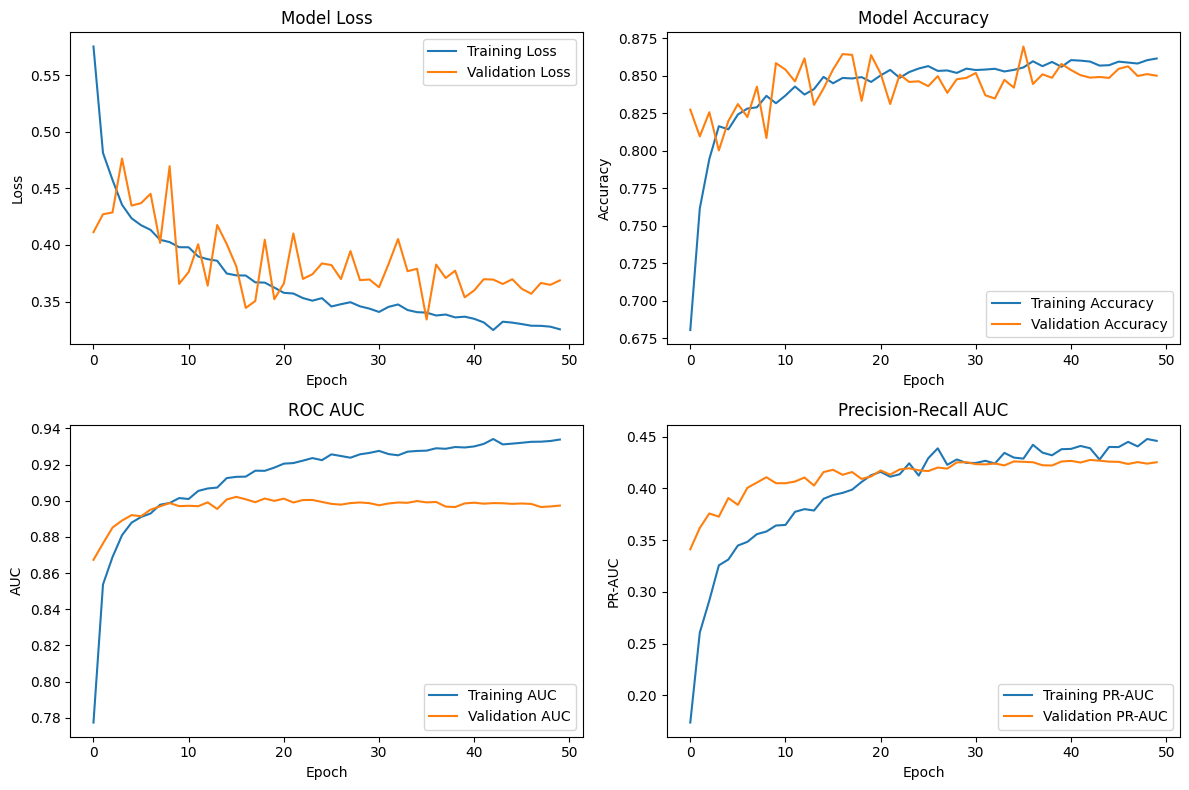


Test Set Performance:
Accuracy: 0.8439
Precision: 0.1951
Recall: 0.8472
ROC AUC: 0.9205
PR AUC: 0.4736

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     22560
           1       0.20      0.85      0.32      1008

    accuracy                           0.84     23568
   macro avg       0.59      0.85      0.61     23568
weighted avg       0.96      0.84      0.89     23568


Confusion Matrix:
[[19036  3524]
 [  154   854]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     22560
           1       0.20      0.85      0.32      1008

    accuracy                           0.84     23568
   macro avg       0.59      0.85      0.61     23568
weighted avg       0.96      0.84      0.89     23568


Confusion Matrix:
[[19036  3524]
 [  154   854]]


In [39]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Loss
axes[0,0].plot(history.history['loss'], label='Training Loss')
axes[0,0].plot(history.history['val_loss'], label='Validation Loss')
axes[0,0].set_title('Model Loss')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()

# Accuracy
axes[0,1].plot(history.history['accuracy'], label='Training Accuracy')
axes[0,1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0,1].set_title('Model Accuracy')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Accuracy')
axes[0,1].legend()

# ROC AUC
axes[1,0].plot(history.history['auc'], label='Training AUC')
axes[1,0].plot(history.history['val_auc'], label='Validation AUC')
axes[1,0].set_title('ROC AUC')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('AUC')
axes[1,0].legend()

# PR AUC
axes[1,1].plot(history.history['pr_auc'], label='Training PR-AUC')
axes[1,1].plot(history.history['val_pr_auc'], label='Validation PR-AUC')
axes[1,1].set_title('Precision-Recall AUC')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('PR-AUC')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
test_loss, test_acc, test_precision, test_recall, test_auc, test_pr_auc = model.evaluate(
    X_test, y_test, verbose=0
)

print(f"\nTest Set Performance:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"ROC AUC: {test_auc:.4f}")
print(f"PR AUC: {test_pr_auc:.4f}")

# Get predictions
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int)

# Additional metrics

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

In [ ]:
# Create submission file
print("Creating submission file...")

# Get test data indices for submission
test_indices = cnn_features.index[test_mask]
test_transcript_ids = [idx[0] for idx in test_indices]
test_positions = [idx[1] for idx in test_indices]

# Create submission dataframe
submission_df = pd.DataFrame({
    'transcript_id': test_transcript_ids,
    'transcript_position': test_positions,
    'score': y_pred_proba.flatten()
})

# Save submission file
submission_df.to_csv('../predictions/dataset0_predictions_cnn.csv', index=False)
print(f"Submission file saved: ../predictions/dataset0_predictions_cnn.csv")
print(f"Shape: {submission_df.shape}")
print(f"Sample predictions:")
print(submission_df.head(10))

# Summary statistics
print(f"\nPrediction Statistics:")
print(f"Mean score: {submission_df['score'].mean():.4f}")
print(f"Std score: {submission_df['score'].std():.4f}")
print(f"Min score: {submission_df['score'].min():.4f}")
print(f"Max score: {submission_df['score'].max():.4f}")
print(f"Predicted positives (>0.5): {(submission_df['score'] > 0.5).sum()}")

Creating submission file...
Submission file saved: cnn_predictions.csv
Shape: (23568, 3)
Sample predictions:
     transcript_id  transcript_position     score
0  ENST00000000233                  244  0.059507
1  ENST00000000233                  261  0.799275
2  ENST00000000233                  316  0.003179
3  ENST00000000233                  332  0.602660
4  ENST00000000233                  368  0.390310
5  ENST00000000233                  404  0.212730
6  ENST00000000233                  431  0.699923
7  ENST00000000233                  440  0.069796
8  ENST00000000233                  471  0.541594
9  ENST00000000233                  539  0.357305

Prediction Statistics:
Mean score: 0.2404
Std score: 0.2901
Min score: 0.0000
Max score: 0.9968
Predicted positives (>0.5): 4378
